In [1]:
import numpy
import scipy.special
import matplotlib.pyplot as plt
import math
plt.rcParams['figure.figsize'] = 14, 10

Solução de Schumann

Números adimensionais definidos:


$$y^{*} = \frac{k_2 z}{v_g}$$

$$t^{*} = k_1 \left(t - \frac{ z}{v_g} \right)$$

onde
$$ k_1 =\frac{h A^{'''}} {c_{p,p} \rho_p \left(1 - \varepsilon_{g} \right)} $$
$$ k_2 =\frac{h A^{'''}}{c_{p,g}\rho_g \varepsilon_{g}} $$

A solução é dada por:

$$ \frac{T_p}{T_0} = 1 - e^{-y -z}\sum_{n=0}^{\infty}y^n M_n \left(y z \right ) = e^{-y -z}\sum_{n=1}^{\infty}z^n M_n \left(y z \right )$$

$$ \frac{T_g}{T_0} = 1 - e^{-y -z}\sum_{n=1}^{\infty}y^n M_n \left(y z \right ) = e^{-y -z}\sum_{n=0}^{\infty}z^n M_n \left(y z \right )$$

E 

$$M_0\left(a \right ) = J_0 \left(2 i \sqrt{a} \right ) $$

$$ M_n\left(a \right ) = \frac{d^n M_0 \left(a \right )}{d a^n}$$

$$h_{g} = \frac{h a}{\varepsilon_{g} \rho_{g} c_{p,g}} = \frac{6 h \left ( {1 - \varepsilon_{g}} \right )}{\varepsilon_{g} \rho_{g} c_{p,g} d_{p}}$$

$$h_{p} = \frac{h a}{\left ( {1 - \varepsilon_{g}} \right ) \rho_{p} c_{p,p}} = \frac{6 h}{\rho_{p} c_{p,p} d_{p}}$$



In [2]:
def NusseltDeenEtAl(Rep,  Prandtl, voidage): 
# Particle Nusselt Number(Deen correlation 
# INPUT
#  Rep Scalar number for the particle Reynolds number
#  Prandtl Scalar number for the Prandtl number
#  voidage  Scalar number for bed voidage

# OUTPUT
#  Nup  Scalar number for Nusselt number
    PrPowOneThird  = math.pow(Prandtl,0.3333333333)
    Nup = ((7.0 - 10.0 * voidage + 5.0 * voidage * voidage ) 
      * (1.0 + 0.17 * math.pow(Rep,0.2) * PrPowOneThird )
      + ( 1.33 - 2.31 * voidage + 1.16 * voidage * voidage )  * math.pow(Rep,0.7)
      * PrPowOneThird)
    return Nup

def NusseltGunn(Re, Pr, alpha_f):
#* Gunn (1978) correlation 


# Gunn1978 - Function to calculate the Nusselt (or Sherwood) number for the heat 
# (or mass) transfer using the Gunn (1978) correlation for dense flow of spherical particles.
# parameters:
# Re = Reynolds number based on particle diameter and relative velocity
# Pr = Prandtl number based on fluid properties (or Schmidt number for mass transfer)
# alpha_f = fluid volume (void) fraction
#
# returns:
# Nu = Gunn (1978) Nusselt (or Sherwood) number

# references:
# GUNN, D.; Transfer of Heat or Mass to Particles in Fixed and Fluidized Beds, 
# International Journal of Heat and Mass Transfer, volume 21, issue 4, pages 467-476, 1978.
# 

    Nu = (7.0 - 10.0 * alpha_f + 5.0 * alpha_f * alpha_f) * (1.0 + 0.7 * numpy.power(Re, 0.2) * numpy.power(Pr, 0.3333333333)) + \
    (1.33 - 2.4 * alpha_f + 1.2 * alpha_f * alpha_f) * numpy.power(Re, 0.7) * numpy.power(Pr, 0.3333333333)

    return Nu;

def packedBedTrnsMn(a,n):

# calculation of  parameters required for Schumann solution

    nMax = 30

    result = 0
    for i in range(n,nMax+1):
        piProduct = 1
        for j in range(0,n):
            piProduct = piProduct * (i-j)
                 
        result =  result + a**(i-n) * piProduct / (numpy.math.factorial(i))**2
    
    return(result)


def packedBedTrnsMnSum(y, z, nStart):
# calculation of summation bessel function required for Schumann solution
# INPUT
#   t  ...vector containing the dimensionless time
#   z  ...vector containing the dimentionless length
# OUTPUT
#   result    ...vector containing intermediate results of the Schumann solution

    nMax = 30

    a = y * z   
    result = 0
    for n in range (nStart,nMax+1):        
        result = result + z**(n) * packedBedTrnsMn(a,n)
    
    return(result)



def packedBedTrnsTemperatures(t, z):
#classical solution of Schumann
# INPUT
#   t         ...vector containing the dimensionless time
#  z         ...vector containing the dimentionless length
# OUTPUT
#   TgStar    ...vector of dimensionless gas temperature along the bed 
#   TpStar    ...vector of dimensionless particle temperature along the bed 

    TgStar =  1 -  numpy.exp(-z-t) * packedBedTrnsMnSum(t, z, 1) 

    TpStar = 1 - numpy.exp(-z-t) * packedBedTrnsMnSum(t, z, 0)
      
    return([TgStar, TpStar])


        

In [120]:
# loading the digitized data

#file = open('T_line_caseAverRadius2.csv', mode='r')
file = open('T_line_caseAverRadiusreallysmall.csv', mode='r')
data = file.read()
file.close()

number_timesteps = data.count('Timestep')
block_size = data.count('\n') // number_timesteps
data = data.split('\n')
print('number of time steps = {0:d}'.format(number_timesteps))
print('data block size = {0:d}'.format(block_size))

temperature = numpy.zeros((number_timesteps, block_size - 3), dtype=numpy.float64)
num_time = numpy.zeros((number_timesteps), dtype=numpy.float64)
num_y = None

for step in range(number_timesteps):
    block = data[step * block_size : (step + 1) * block_size]
    num_time[step] = float(block[1].split(',')[1])
    temperature[step] = numpy.loadtxt(block, dtype=numpy.float64, delimiter=',', skiprows=3, usecols=4)
    if step == 0:
        num_y = numpy.loadtxt(block, dtype=numpy.float64, delimiter=',', skiprows=3, usecols=1)

print(num_time)
print(num_y)
print(temperature[0][0])

print(num_y.shape, temperature[10].shape, num_time[10])
print(num_time.shape, temperature[:, -1].shape, num_y[-1])
print(num_time.shape, temperature[:, -1].shape, num_y[0])
#num_y = num_y - 0.15
num_y = num_y - 0.145



number of time steps = 238
data block size = 84
[ 0.0199446  0.0398893  0.0598339  0.0797786  0.0997232  0.119668   0.139613
  0.159557   0.179502   0.199446   0.219391   0.239336   0.25928    0.279225
  0.29917    0.319114   0.339059   0.359004   0.378948   0.398893   0.418838
  0.438782   0.458727   0.478671   0.498616   0.518561   0.538505   0.55845
  0.578395   0.598339   0.618284   0.638229   0.658173   0.678118   0.698063
  0.718007   0.737952   0.757896   0.777841   0.797786   0.81773    0.837675
  0.85762    0.877564   0.897509   0.917454   0.937398   0.957343   0.977288
  0.997232   1.01718    1.03712    1.05707    1.07701    1.09696    1.1169
  1.13684    1.15679    1.17673    1.19668    1.21662    1.23657    1.25651
  1.27646    1.2964     1.31635    1.33629    1.35624    1.37618    1.39613
  1.41607    1.43601    1.45596    1.4759     1.49585    1.51579    1.53574
  1.55568    1.57563    1.59557    1.61552    1.63546    1.65541    1.67535
  1.69529    1.71524    1.73518    

In [116]:
# fluid properties
rho_g = 1000 # [kg/m³] fluid density [kg/m^3]
mu_g = 0.001 # [Pa·s]  dynamic viscosity of fluid 
nu_g = mu_g/rho_g  # [kg/(m.s)] kinematic viscosity of fluid 
c_pg = 4000.0 # [J/kg·K] fluid heat capacity [J/(kg.K)]
#c_pg = 4187.0 # [J/kg·K] fluid heat capacity [J/(kg.K)]
T_gi = 500.0 # [K] inlet fluid temperature [K]
T_g0 = 300.0 # [K] initial fluid temperature [K]
#k_g = 0.5  # [J/(m.K)] fluid conductivity 
k_g = 0.6  # [J/(m.K)] fluid conductivity 
Pr_g = c_pg*mu_g/k_g # [ ] Prandtl number 
print(Pr_g)


#particle properties
d_p = 0.00395 # [m] particle diameter [m]
rho_p = 5000.0 # [kg/m³] density of particle[kg/m^3]
#rho_p = 8400.0 # [kg/m³] density of particle[kg/m^3]
#c_pp = 400.0 # [J/kg·K] particle heat capacity [J/(kg.K)]
c_pp = 385.0 # [J/kg·K] particle heat capacity [J/(kg.K)]
T_p0 = T_g0 # [K] initial particle temperature
k_p = 0.0  # [J/(m.K)] particle conductivity 
#k_p = 0.025  # [J/(m.K)] particle conductivity 
q_dot = 0.0 # [W/m³]
q_dot_spec = 0.0 #[kJ/(kg.s)] specific heat source 

#Mesh size
l_mesh = 10.0/1000 #m

#operating conditions
U_s = 0.1 # [m/s] superficial velocity

epsilon_g = 0.3849 # gas volume fraction [dimensionless][ ] 
U = U_s/ epsilon_g   # [m/s] this is the TRUE gas velocity, not superficial [m/s]
#h = 1.0 # [W/m²·K]


6.666666666666667


In [117]:
Rep = epsilon_g * d_p * U / nu_g #Re of particle using TRUE velocity
Re_sup = epsilon_g * d_p * U_s / nu_g #Re of particle using superficial velocity
                  
Nup = NusseltDeenEtAl(Re_sup, Pr_g, epsilon_g)
Nu_gunn = NusseltGunn(Re_sup, Pr_g, epsilon_g)
print("epsilon = ", epsilon_g)
print("Pr = ", Pr_g)
print("Re = ", Rep)
print("Nup = ", Nup)
print("Nup_sup = ", Nu_gunn)
print("Peclet number = ", Rep * Pr_g)


#h = k_g * Nup / d_p;
h = k_g * Nu_gunn / d_p;

h_g = (6.0 * h * (1.0 - epsilon_g)) / (epsilon_g * rho_g * c_pg * d_p)
h_p = (6.0 * h) / (rho_p * c_pp * d_p)

hStar = h_g/h_p
#print(hStar)
print("h_g = ", h_g)
print("h_p = ", h_p)
hpg = h_p + h_g

#hEvapStar   = q_dot_spec / (0.523599 * ((d_p)**3.0) * rho_p * c_pp) *(Tg-Tp)
   
#aEvapParticle= h_g * h_p * hEvapStar / (hpg * hpg)





epsilon =  0.3849
Pr =  6.666666666666667
Re =  395.00000000000006
Nup =  46.13189738384939
Nup_sup =  54.9151399216
Peclet number =  2633.333333333334
h_g =  5.06218751778
h_p =  6.5821787207


T inicial =  484.49


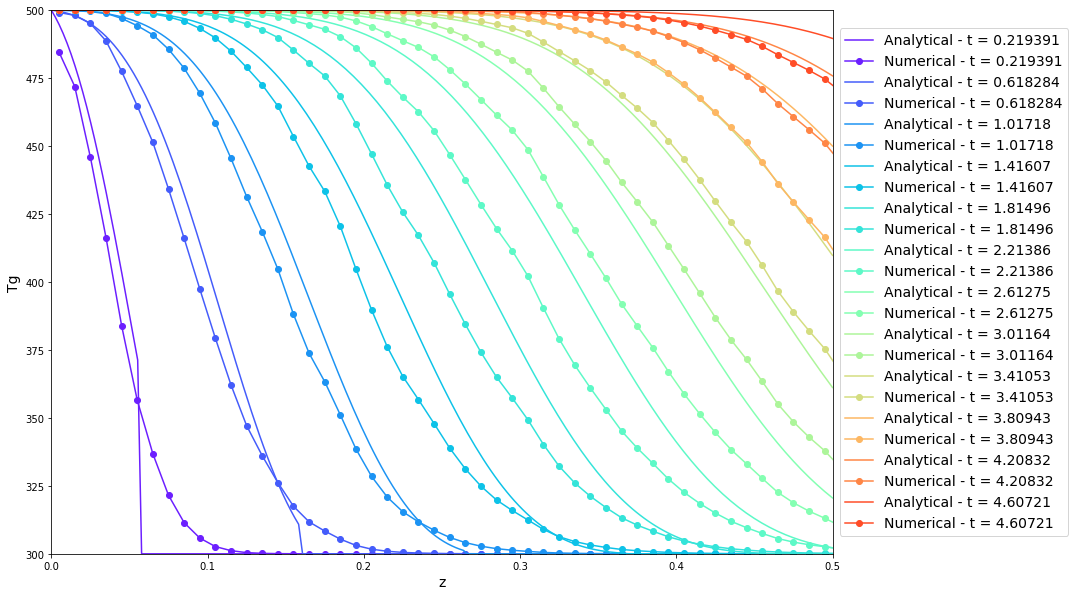

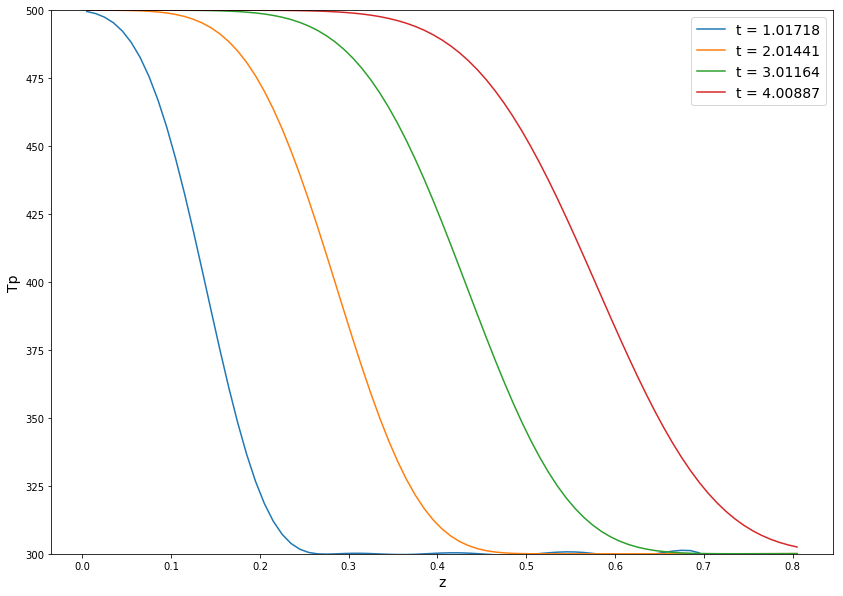

In [128]:
#Main plot switches

print("T inicial = ", temperature[10][0])
#T_gi = temperature[75][:lmax+1][-1]
#t = num_time[75:]-1.5
#print(t)
i = 10
inc = 20
cmap = plt.get_cmap('rainbow')
y = numpy.linspace(0.5, 0, 200)
for time in num_time[i::inc]:
    
    zStar = (y * h_g / U)

    tStart = time*h_p - (y/U)*h_p

    TgStart = packedBedTrnsTemperatures(tStart,zStar )[0]

    Tg = TgStart*(T_gi-T_g0) + T_g0
    #print(tStart)
    for index, value in enumerate(Tg[numpy.where(tStart < 0.0)]):
        Tg[index] = T_g0
    plt.plot(y, Tg, color = cmap(i), label = "Analytical - t = " + str(time) )
    plt.plot(num_y, temperature[i], marker = 'o', color = cmap(i), label = "Numerical - t = " + str(time) )
    i = i + inc
plt.ylim(300, 500)     
plt.xlim(0, 0.5) 
#plt.legend(fontsize=12, loc='upper center', bbox_to_anchor=(0.5, 1.25), ncol=3, fancybox=True)
plt.legend(fontsize=14, loc='center left', bbox_to_anchor=(1, 0.5))
plt.ylabel('Tg', fontsize=14)
plt.xlabel('z', fontsize=14)
plt.show()

for time in num_time[50::50]:
    zStar = (num_y * h_g / U)
    tStart = time*h_p - (num_y/U)*h_p
    TpStart = packedBedTrnsTemperatures(tStart,zStar )[1]
    Tp = TpStart*(T_gi-T_g0) + T_g0
    plt.plot(num_y, Tp, label = "t = " + str(time) )

plt.ylim(300, 500)        
plt.legend(fontsize=14)
plt.ylabel('Tp', fontsize=14)
plt.xlabel('z', fontsize=14)
plt.show()




(238, 81)
(238,)
(81,)
tStar.shape =  (238,)
T.shape =  (238,)
(238,)
tStar.shape =  (238,)
T.shape =  (238,)
(238,)
tStar.shape =  (238,)
T.shape =  (238,)
(238,)
tStar.shape =  (238,)
T.shape =  (238,)
(238,)
tStar.shape =  (238,)
T.shape =  (238,)
(238,)
tStar.shape =  (238,)
T.shape =  (238,)
(238,)
tStar.shape =  (238,)
T.shape =  (238,)
(238,)
tStar.shape =  (238,)
T.shape =  (238,)
(238,)


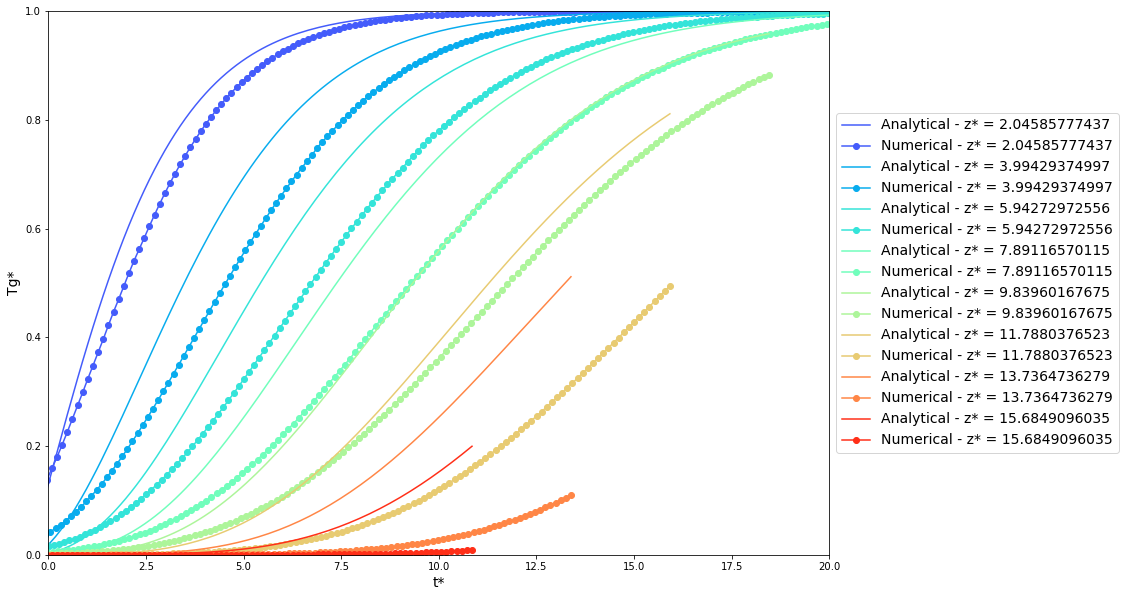

In [127]:
i=10
inc = 10
cmap = plt.get_cmap('rainbow')
y = 0.25
print(temperature.shape)
print(num_time.shape)
print(num_y.shape)

for y in num_y[i::10]:
    zStar = (y * h_g / U)  
    tStar = num_time*h_p - (y/U)*h_p
    TgStar = packedBedTrnsTemperatures(tStar,zStar )[0]
    print("tStar.shape = ", tStar.shape)
    print("T.shape = ", temperature[:,i].shape)
    print(TgStar.shape)
    Tg = TgStar*(T_gi-T_g0) + T_g0
    plt.plot(tStar, TgStar, color = cmap(i*3), label = "Analytical - z* = " + str(zStar) )
    plt.plot(tStar, ((temperature[:,i]- T_g0)/(T_gi-T_g0)), marker = 'o', color = cmap(i*3), label = "Numerical - z* = " + str(zStar) )
    i = i+inc
plt.xlim(0, 20)     
plt.ylim(0, 1) 
#plt.legend(fontsize=12, loc='upper center', bbox_to_anchor=(0.5, 1.25), ncol=3, fancybox=True)
plt.legend(fontsize=14, loc='center left', bbox_to_anchor=(1, 0.5))
plt.ylabel('Tg*', fontsize=14)
plt.xlabel('t*', fontsize=14)
plt.show()

# for time in num_time[50::50]:
#     zStar = (num_y * h_g / U)
#     tStart = time*h_p - (num_y/U)*h_p
#     TpStart = packedBedTrnsTemperatures(tStart,zStar )[1]
#     Tp = TpStart*(T_gi-T_g0) + T_g0
#     plt.plot(num_y, Tp, label = "t = " + str(time) )

# plt.ylim(300, 500)        
# plt.legend(fontsize=14)
# plt.ylabel('Tp', fontsize=14)
# plt.xlabel('z', fontsize=14)
# plt.show()

In [123]:


# # fluid properties
# rho_g = 1000 # [kg/m³] gas density [kg/m^3]
# mu_g = 0.001 # [Pa·s]  dynamic viscosity of gas 
# nu_g = mu_g/rho_g  # [kg/(m.s)] kinematic viscosity of gas 
# c_pg = 400.0 # [J/kg·K] gas heat capacity [J/(kg.K)]
# T_gi = 500.0 # [K] inlet gas temperature [K]
# T_g0 = 300.0 # [K] initial gas temperature [K]
# k_g = 0.6  # [J/(m.K)] gas conductivity 
# Pr_g = c_pg*mu_g/k_g # [ ] Prandtl number 
# print(Pr_g)


# #particle properties
# d_p = 0.00395 # [m] particle diameter [m]
# rho_p = 5000.0 # [kg/m³] density of particle[kg/m^3]
# c_pp = 400.0 # [J/kg·K] particle heat capacity [J/(kg.K)]
# T_p0 = T_g0 # [K] initial particle temperature
# k_p = 0.0  # [J/(m.K)] gas conductivity 
# q_dot = 0.0 # [W/m³]
# q_dot_spec = 0.05 #[kJ/(kg.s)] specific heat source 

# #operating conditions
# U_s = 0.1 # [m/s] superficial velocity
# U = 0.165   # [m/s] this is the TRUE gas velocity, not superficial [m/s]
# epsilon_g = 0.5 # gas volume fraction [dimensionless][ ] 
# #h = 1.0 # [W/m²·K]

# ap = 6.0 * (1.0 - epsilon_g) / d_p

# Rep = epsilon_g * d_p * U / nu_g #Re of particle using SUPERFICIAL velocity
                  
# Nup = NusseltDeenEtAl(Rep, Pr_g, epsilon_g)
# print("epsilon = ", epsilon_g)
# print("Pr = ", Pr_g)
# print("Re = ", Rep)
# print("Nup = ", Nup)
# print(NusseltDeenEtAl(100, 0.1, 0.5))


# h = k_g * Nup / d_p;

# h_g = (6.0 * h * (1.0 - epsilon_g)) / (epsilon_g * rho_g * c_pg * d_p)
# h_p = (6.0 * h) / (rho_p * c_pp * d_p)
# h_q = q_dot / ((1.0 - epsilon_g) * rho_p * c_pp)

# hStar = h_g/h_p
# print(hStar)
# print(h_g)
# hpg = h_p + h_g

# #hEvapStar   = q_dot_spec / (0.523599 * ((d_p)**3.0) * rho_p * c_pp) *(Tg-Tp)
   
# #aEvapParticle= h_g * h_p * hEvapStar / (hpg * hpg)

